In [ ]:
# hide
# all_tutorial
! [ -e /content ] && pip install -Uqq mrl-pypi  # upgrade mrl on colab

# Tutorial - Pretrained Models

>Using MRL pretrained models

## Pretrained Models

The use of pretrained models has had a pronounced impact on computer vision and natural language processing. Pretrained models are initially trained on large datasets. This allows the models to develop high quality representations built on a large chunk of the data landscape. These models can then be applied to downstream tasks that may be more limited in terms of available data. Fine-tuning a pretrained model on a smaller dataset almost always results in improved performance compared to training from scratch on a small dataset.

The MRL library provides a large number of pretrained generative models for multiple data modalities. These models have been trained on large datasets to generate small molecules (whole compounds, r-groups, linkers), polymers (generated as monomers), nucleic acid sequences and protein sequences. The full list of pretrained models can be found at the <a href="/mrl/model_zoo.html">Model Zoo</a> page.

When using these models, it is common to first fine-tune them on a dataset that better represents the desired search space. This tutorial shows how to load a pretrained model and fine-tune it on a new dataset.

## Performance Notes

If running on Collab, remember to change the runtime to GPU

In [ ]:
import sys
sys.path.append('..')

from mrl.imports import *
from mrl.chem import *
from mrl.model_zoo import LSTM_LM_Small_ZINC

/home/dmai/miniconda3/envs/mrl/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterCatalogEntry const> already registered; second conversion method ignored.
  return f(*args, **kwds)


Here we load the `LSTM_LM_Small_ZINC` pretrained model. This is a 3-layer LSTM model trained on ~79 million compounds from the ZINC library

In [ ]:
agent = LSTM_LM_Small_ZINC()

In [ ]:
agent.model

LSTM_LM(
  (embedding): Embedding(47, 256)
  (lstm): LSTM(
    (input_drop): SequenceDropout()
    (lstm_drop): SequenceDropout()
    (lstms): ModuleList(
      (0): LSTM(256, 1024, batch_first=True)
      (1): LSTM(1024, 1024, batch_first=True)
      (2): LSTM(1024, 256, batch_first=True)
    )
  )
  (head): Linear(in_features=256, out_features=47, bias=True)
)

We can generate compounds by sampling from the model

In [ ]:
smiles = agent.sample_and_reconstruct(100, 100)
mols = to_mols(smiles)

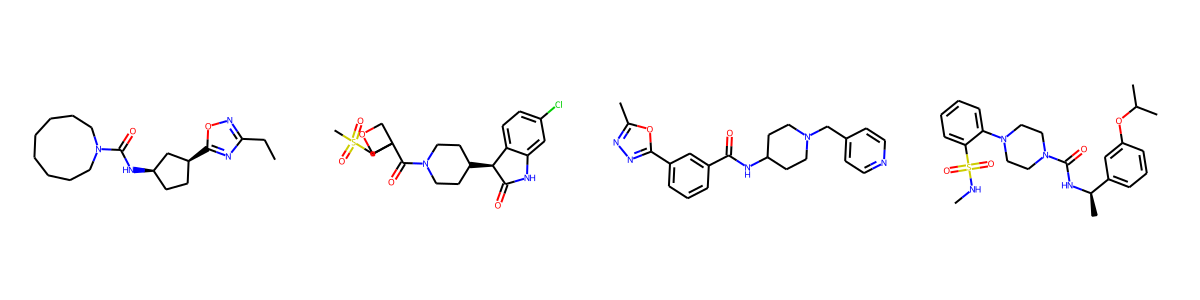

In [ ]:
draw_mols(mols[:4], mols_per_row=4)

Now we read in our dataset. This is just a toy dataset to illustrate the API. More realistically, this could be a designed library. For example, a library containing molecules built on a specific scaffold of interest

In [ ]:
# if in the repo
df = pd.read_csv('../files/smiles.csv')

# if in Collab:
# download_files()
# df = pd.read_csv('files/smiles.csv')

In [ ]:
df

,smiles
0,CNc1nc(SCC(=O)Nc2cc(Cl)ccc2OC)nc2ccccc12
1,COc1ccc(C(=O)Oc2ccc(/C=C3\C(=N)N4OC(C)=CC4=NC3...
2,Cc1sc(NC(=O)c2ccccc2)c(C(N)=O)c1C
3,COc1ccc(NCc2noc(-c3ccoc3)n2)cc1OC(F)F
4,O=C(COC(=O)c1cccc(Br)c1)c1ccc2c(c1)OCCCO2
...,...
1995,C/C(=N/NC(=O)CN(c1ccccc1Br)S(C)(=O)=O)c1ccc2c(...
1996,CCC(=O)Nc1ccc(NC(=O)NCCc2cccs2)cc1C
1997,CCC(CC)(NC(=O)Cc1c(F)cccc1F)/C(N)=N/O
1998,CC(=O)c1ccc(NC(=O)CNC(=O)c2ccccc2C)cc1C


Here we load our dataset into the `agent`

In [ ]:
agent.update_dataset_from_inputs(df.smiles.values)

Now we train. An important question here is how much fine-tuning should be done. This is something you have to feel out based on the size of your fine-tuning dataset and the needs of the downstream tasks. Fine-tuning extensively on a small dataset can lead to mode collapse in the resulting model. On the other hand, not doing enough fine-tuning can lead to a model that fails to generate compounds of interest.

As a general rule of thumb, `1e-5` works well as an initial learning rate for fine-tuning. Depending on your dataset, higher learning rates (`1e-4` or `1e-3`) may be appropriate.

In [ ]:
agent.train_supervised(32, 1, 1e-5)

Epoch,Train Loss,Valid Loss,Time
0,0.60565,0.53878,00:04


When first fine-tuning on a new dataset, a good approach is to fine-tune at a lower learning rate for 1 epoch at a time, monitoring the generated compounds after each training epoch. Generate 2000+ compounds and check the generated dataset for percent unique and percent valid compounds.

If the fine-tuning dataset represents a specific, opinionated chemical space (ie specific scaffolds), spot check compounds to see if the model has adapted to the fine-tuning dataset.

Continue fine-tuning until generated compounds look acceptable, so long as percent unique and percent valid metrics are high

In [ ]:
smiles = agent.batch_sample_and_reconstruct(4000, 512, 90)

mols = to_mols(smiles)

percent_valid = len([i for i in mols if i is not None])/len(mols)
percent_unique = len(set(smiles))/len(smiles)

print(f'Percent Valid: {percent_valid:.3f}, Percent Unique: {percent_unique:.3f}')

Percent Valid: 0.981, Percent Unique: 1.000
